<a href="https://colab.research.google.com/github/marathomas/meerkat/blob/master/02_meerkat_UMAP_projections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites

- Project folder should already exist, save path as PROJECT_PATH
- Project folder must contain subfolder called "in_labels", containing all label tables in csv format 
- Project folder must contain subfolder called "in_wavs", containing all audio files

### Mounting drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


or "Mount Drive" in Files menu

### Installing and loading libraries

(software installations within Google Colaboratory are not persistent, need to reinstall libraries every time you (re-)connect to an instance)

In [1]:
import os
import pandas as pd
import sys
import re
import json
os.system('pip install "librosa==0.7.1"')
import librosa
import librosa.display
import numpy as np
import statistics
import matplotlib.pyplot as plt
from datetime import time
from datetime import datetime
import glob
from pandas.core.common import flatten
import shutil
import pickle
os.system('pip install pathlib2') # need to install
import pathlib2
import psutil
import datetime
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import umap
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Setting constants

Setting project, input and output folders.

In [4]:
PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"

os.chdir(PROJECT_PATH)

### Installing AVGN

Cloning the AVGN_paper repository:

In [ ]:
os.chdir(PROJECT_PATH)

if (not os.path.exists(PROJECT_PATH+'avgn_paper')):
  print("Cloning Repo")
  os.mkdir("avgn_paper")
  os.chdir("avgn_paper")
  os.sytem('git clone https://github.com/timsainb/avgn_paper.git')
else:
  print("Repo already present")
  os.chdir("avgn_paper")

os.system('python setup.py develop')

from importlib.machinery import SourceFileLoader
avgn = SourceFileLoader('avgnpaper/avgn', PROJECT_PATH+'avgn_paper/avgn/'+'utils/__init__.py').load_module()
import avgn

Repo already present


### Functions

In [5]:
# Function that pads a spectrogram with zeros to a certain length
# Input: spectrogram (2D np array)
#        maximal length (Integer)
# Output: Padded spectrogram (2D np array)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

# UMAP projection

### Preparation

Choose dataset

In [187]:
#df = pd.read_pickle(DATA+'df_denoised') # full
#df = pd.read_pickle(DATA+'df_denoised_less_cols') # full
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
#df = pd.read_pickle(DATA+'embedding_denoised_stretched_mfcc_delta_balanced')

df['index_id'] = df.index

Set spec_df to desired dataset

In [188]:
# A) Full
spec_df = df
dftype='full'
dftype='balanced'

In [ ]:
# B) Partial
#spec_df = df[df.call_lable == 'cc']
#dftype='cc'
#spec_df = df[df.call_lable != 'cc']
#dftype='non-cc'
spec_df = df[df.soundfoc_yn == 'n']
dftype='nonfoc'

In [ ]:
# C) Analysis for individuals
pd.crosstab(index=df["indv"],
            columns="count") 

ind = 'VCVM001'
spec_df = df[df.indv == ind]
dftype='indv_'+ind

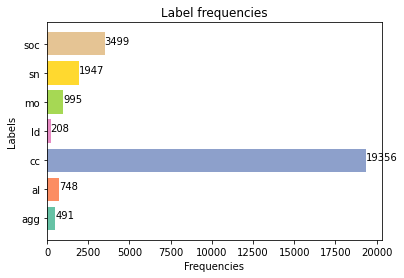

In [ ]:
labelcounts = pd.DataFrame(df['call_lable'].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts.call_lable.values, color = pal)

for index, value in enumerate(labelcounts.call_lable.values):
    plt.text(value, index, str(value))

plt.title('Label frequencies')
plt.ylabel('Labels')
plt.xlabel('Frequencies')

plt.show()

In [ ]:
# D) Balanced classes
wo_cc_df = spec_df[spec_df.call_lable != 'cc']
cc_df = spec_df[spec_df.call_lable == 'cc']
cc_subset = cc_df.sample(frac=0.1, replace=False, random_state=1)
spec_df = pd.concat((wo_cc_df, cc_subset), ignore_index=False, axis=0)

dftype=dftype+'_balanced'

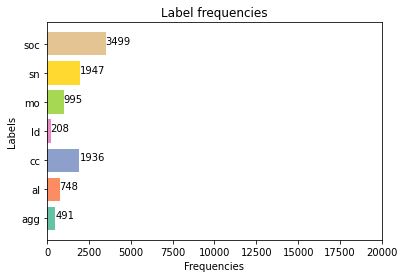

In [ ]:
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts.call_lable.values, color = pal)

for index, value in enumerate(labelcounts.call_lable.values):
    plt.text(value, index, str(value))

plt.title('Label frequencies')
plt.ylabel('Labels')
plt.xlabel('Frequencies')
plt.xlim(0,20000)

plt.show()

Completely balanced

In [ ]:
# E) Completely balanced classes
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
class_size = np.min(labelcounts.call_lable.values)

subsets = []
for label, num in zip(labelcounts.index, labelcounts.call_lable.values):
  print(label, ":", num, ":", class_size/num)
  subsets.append(spec_df[spec_df.call_lable == label].sample(frac=(class_size/num), replace=False, random_state=1))

spec_df = pd.concat(subsets, axis=0)
dftype = 'complete_balanced'
#pd.DataFrame(spec_df['call_lable'].value_counts())

soc : 3499 : 0.059445555873106605
sn : 1947 : 0.10683102208525937
cc : 1936 : 0.10743801652892562
mo : 995 : 0.20904522613065327
al : 748 : 0.27807486631016043
agg : 491 : 0.42362525458248473
ld : 208 : 1.0


## Divide certain and uncertain

In [ ]:
certain_df = spec_df[spec_df.certain_yn == 'y']
uncertain_df = spec_df[spec_df.certain_yn == 'n']

In [ ]:
certain_df.shape

(5653, 24)

In [ ]:
uncertain_df.shape

(130, 24)

In [ ]:
df.columns

Index(['Name', 'Start', 'Duration', 'Time Format', 'Type', 'Description',
       'call_yn', 'start_s', 'duration_s', 'stop_s', 'date', 'samplerate_hz',
       'indv', 'original_wav', 'bout_number', 'call_lable', 'raw_audio',
       'spectrograms', 'mfccs', 'mfcc_deltas', 'mfcc_deltadeltas',
       'soundfoc_yn', 'stretched_spectrograms', 'stretched_mfccs',
       'stretched_mfcc_deltas', 'stretched_mfcc_deltadeltas',
       'denoised_spectrograms', 'denoised_stretched_spectrograms',
       'denoised_mfccs', 'denoised_stretched_mfccs', 'denoised_mfcc_deltas',
       'denoised_stretched_mfcc_deltas'],
      dtype='object')

## Choose features

Set specs to desired data and declare method with String. We can use melspectrograms (A) or MFCCs (B). 

In [ ]:
spec_df.columns

Index(['duration_s', 'samplerate_hz', 'indv', 'original_wav', 'bout_number',
       'call_lable', 'raw_audio', 'spectrograms', 'mfccs', 'mfcc_deltas',
       'mfcc_deltadeltas', 'soundfoc_yn', 'stretched_spectrograms',
       'stretched_mfccs', 'stretched_mfcc_deltas',
       'stretched_mfcc_deltadeltas', 'denoised_spectrograms',
       'denoised_stretched_spectrograms', 'denoised_mfccs',
       'denoised_stretched_mfccs', 'denoised_mfcc_deltas',
       'denoised_stretched_mfcc_deltas'],
      dtype='object')

In [ ]:
# A.1) Using mel spectrograms:
specs = spec_df.spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'melspectro'

In [ ]:
# A.2) Using stretched mel spectrograms:
specs = spec_df.stretched_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'stretched_melspectro'

In [ ]:
# A.3) Using denoised stretched mel spectrograms:
specs = spec_df.denoised_stretched_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'denoised_stretched_melspectro'

In [12]:
# A.3) Using denoised mel spectrograms:
specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'denoised_melspectro'

In [ ]:
lengths = []

for spec in specs:
  lengths.append(spec.shape[1])

np.mean(np.asarray(lengths))

45.59782166123779

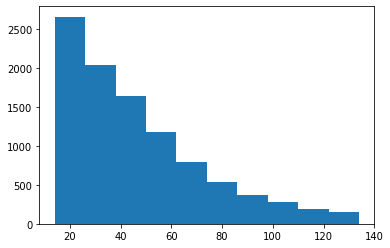

In [ ]:
n, bins, patches = plt.hist(lengths)

In [ ]:
# B.1) Using MFCCs:
specs = spec_df.mfccs.values
method='mfcc'

In [189]:
# B.2) Using stretched MFCCs:
specs = spec_df.stretched_mfccs.values
method='stretched_mfcc'

In [ ]:
# B.3) Using stretched denoised MFCCs:
specs = spec_df.denoised_stretched_mfccs.values
method='denoised_stretched_mfcc'

In [ ]:
# B.4) Using denoised MFCCs:
specs = spec_df.denoised_mfccs.values
method='denoised_mfcc'

In [ ]:
specs = spec_df.denoised_stretched_spectrograms_enhanced_3.values
method = 'denoised_stretched_spectrograms_enhanced_3'

In [ ]:
specs = spec_df.denoised_stretched_spectrograms_edges.values
method = 'denoised_stretched_spectrograms_edges'

In [ ]:
flattened = [spec.flatten() for spec in cleaned_spectrograms]

In [ ]:
specs_arr = np.asarray(flattened)
spectro_data = StandardScaler().fit_transform(pd.DataFrame(specs_arr))
data = spectro_data

Pad with zeros and normalize

In [190]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

# Normalize
data = StandardScaler().fit_transform(pd.DataFrame(data))

In [15]:
data.shape

(9824, 5360)

**Optional: Include deltas in feature vector**

Can choose deltas or delta-deltas

In [ ]:
# A.1) MFCC Deltas
deltas = spec_df.mfcc_deltas.values
method =method+'_delta'

In [ ]:
# A.2) MFCC Deltas stretched
deltas = spec_df.stretched_mfcc_deltas.values
method =method+'_delta'

In [ ]:
# A.3) MFCC Deltas stretched denoised
deltas = spec_df.denoised_stretched_mfcc_deltas.values
method =method+'_delta'

In [ ]:
# A.4) MFCC Deltas denoised
deltas = spec_df.denoised_mfcc_deltas.values
method =method+'_delta'

In [ ]:
# B.1) MFCC Deltadeltas
deltas = spec_df.mfcc_deltadeltas.values
method =method+'_deltadelta'

Or duration

In [ ]:
from scipy.stats import zscore

In [ ]:
dur = zscore(spec_df.duration_s.values)
data = pd.DataFrame(data)
data['dur'] = dur
data = np.asarray(data)

Pad and normalize

In [ ]:
maxlen= np.max([delta.shape[1] for delta in deltas])
flattened_deltas = [pad_spectro(delta, maxlen).flatten() for delta in deltas]
deltas_arr = np.asarray(flattened_deltas)

delta_data = StandardScaler().fit_transform(pd.DataFrame(deltas_arr))
#delta_data = pd.DataFrame(deltas_arr)

Concatenate:

In [ ]:
data = np.concatenate((spectro_data, delta_data), axis=1)

## Running UMAP

In [ ]:
n_neighbors = 15
n_components

In [ ]:
reducer = umap.UMAP(low_memory=True, n_neighbors = 20, n_components = 3) #  low values of min_dist will result in clumpier embeddings
reducer = umap.UMAP(low_memory=True, n_components = 3, min_dist=0) 

In [221]:
call_labels = np.asarray(pd.factorize(spec_df.call_lable.values))
call_labels = call_labels[0]

array([0, 0, 0, ..., 6, 6, 6])

In [222]:
# Supervised!
call_labels = np.asarray(pd.factorize(spec_df.call_lable.values))
call_labels = call_labels[0]

reducer = umap.UMAP(low_memory=True,n_components = 10, target_weight=0.2)
embedding = reducer.fit_transform(data,y=call_labels) # supervised dim reduction

In [191]:
reducer = umap.UMAP(low_memory=True, n_components = 10)

In [192]:
embedding = reducer.fit_transform(data)
embedding.shape # (27244, 2) all

(9824, 10)

### Save embedding



In [30]:
embedding = pd.DataFrame(embedding)
embedding['index_id'] = spec_df['index_id'].values

embedding_filename = 'embedding_'+method+'_'+dftype

print(DATA+embedding_filename)
embedding.to_pickle(DATA+embedding_filename)

/content/drive/My Drive/meerkat/data/embedding_denoised_melspectro_balanced


## Visualization

### 3D Plots

#### Matplotlib animation

In [193]:
umap_df = spec_df

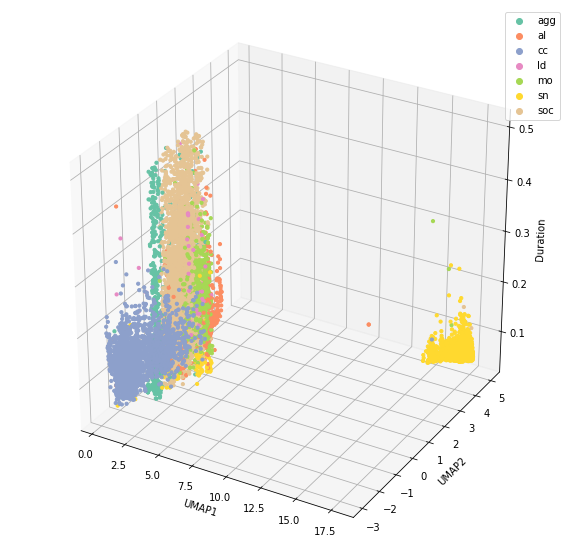

In [223]:
# https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = umap_df.call_lable.values
#scat_labels = aggl_clusterer.labels_
#scat_labels = kmeans.labels_
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               #xs = umap_df['UMAP1'],
               #ys = umap_df['UMAP2'],
               #zs = embedding[:,2],
               zs= umap_df.duration_s.values,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

#ax.set_xlabel('tSNE1')
#ax.set_ylabel('tSNE2')
ax.set_zlabel('Duration')
#ax.set_zlabel('UMAP3')

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

plt.show()

Animation:

In [ ]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+'melpectro_denoised.gif', dpi=80, writer='pillow', fps=12)

# Play animation
# this is the part which makes it work on Colab
#rc('animation', html='jshtml')
#anim

#### Plotly

In [225]:
#t = np.linspace(0, 10, 50)
x, y, z = embedding[:,0], embedding[:,1], embedding[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]
scat_labels = umap_df.call_lable.values
labeltypes = sorted(list(set(scat_labels)))
# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    #zaxis_title='UMAP3'),
                    zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

### 2D plots

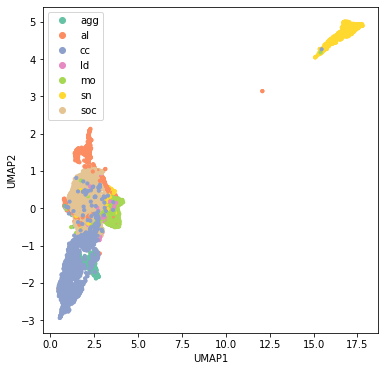

In [224]:
# 2D plot

fig = plt.figure(figsize=(6,6))
scat_labels = umap_df.call_lable.values
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

plt.scatter(embedding[:,0], embedding[:,1], alpha=1,
            s=10, c=c)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2');

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
plt.legend(scatters, labeltypes, numpoints = 1)
plt.show()

### AVGN Plots

In [ ]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [ ]:
z  = list(embedding)
z = np.vstack(z)

# Use spectrogram examples
#specs = spec_df.spectrograms.values
#specs = spec_df.stretched_spectrograms.values
specs = spec_df.denoised_stretched_spectrograms.values

#### By individual

/content/drive/My Drive/meerkat/figures/2020-06-26_vocoder_stretched_mfcc_delta_cc_ind


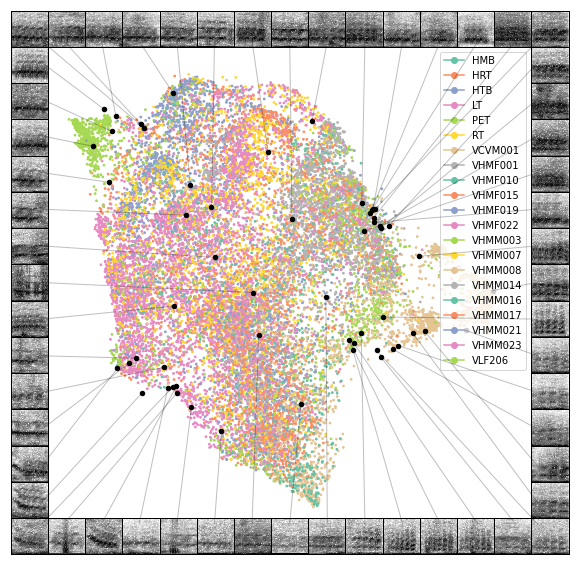

In [ ]:
scatter_spec(
    z,
    specs,
    column_size=15,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.indv.values,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_ind'
save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

#### By label

/content/drive/My Drive/meerkat/figures/2020-07-03_denoised_stretched_mfcc_delta_complete_balanced_call


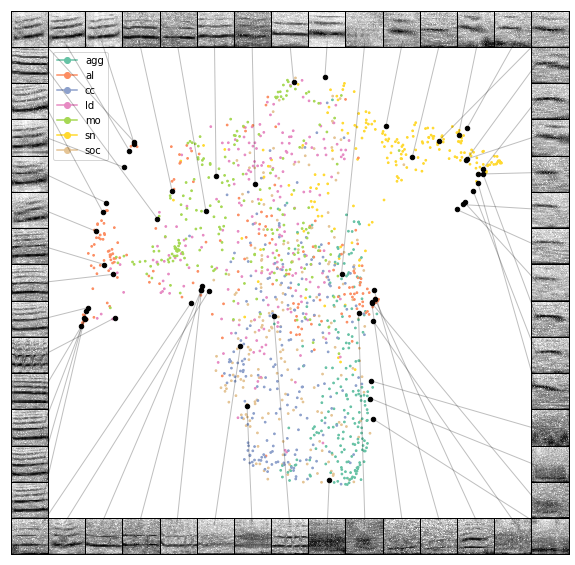

In [ ]:
scatter_spec(
    z,
    specs,
    column_size=15,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.call_lable.values,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_call'
#save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

#### By recording type (focal or nonfocal)

In [ ]:
scatter_spec(
    z,
    specs,
    column_size=15,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.soundfoc_yn.values,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_soundfoc'
#save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

# Embedding evaluation

Evaluate the embedding. Since it's unsupervised, this is really difficult. Best would be to have a measure of dissimilarity that we trust but there's no obvious choice. VGG Net similarity would be an option.

Thus, for now, evaluate it based on the labelled calls.

In [ ]:
# Add duration
embedding_df = pd.DataFrame(embedding)
embedding_df['duration'] = umap_df.duration_s.values

embedding = np.asarray(embedding_df)
embedding_df.head(3)

In [226]:
#df = pd.read_pickle(DATA+'embedding_denoised_stretched_mfcc_delta_balanced')
calltypes = sorted(list(set(df['call_lable'])))

#embedding_vars = ['UMAP1', 'UMAP2', 'duration_s'] 
#embedding = np.asarray(df[embedding_vars])
labels = df.call_lable.values

# Normalize
scaler = MinMaxScaler(feature_range=(0,10))
scaler.fit(embedding)
embedding = scaler.transform(embedding)
metric_type = 'euclidean'

## Find nearest neighbors

In [227]:
k=10

# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [228]:
nn_stats_dict = {}

for calltype in calltypes:
  call_indices = np.asarray(np.where(labels==calltype))[0]
  calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

  for i,ind in enumerate(call_indices):
    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:
      neighbor_label = labels[neighbor]
      calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
  nn_stats_dict[calltype] = calltype_counts

## Find nearest neighbors with annoy

In [ ]:
os.system('pip install annoy')
from annoy import AnnoyIndex
from sklearn.preprocessing import MinMaxScaler

In [ ]:
embedding[0:4,]

array([[3.44249552, 4.57482849, 2.84444444],
       [3.33869899, 5.10651035, 5.93333333],
       [1.61811777, 4.68706919, 3.15555556],
       [1.14964103, 2.72640925, 1.86666667]])

In [ ]:
embedding = np.load(DATA+'result.npy')
vgg_indices = np.load(DATA+'vgg_indices.npy')
df = df.loc[vgg_indices] # sort by vgg indices
labels = df.call_lable.values
metric_type = 'angular'

Evaluate embeddings based on the label classes of the k nearest neighbors in the embedded space.

In [ ]:
# Setting variables

dims = embedding.shape[1]
k = 10
trees = 1000

In [ ]:
# Build annoy tree for NN search

t = AnnoyIndex(dims, metric=metric_type)
for i in range(embedding.shape[0]):
  t.add_item(i, embedding[i,:])

t.build(trees)

True

In [ ]:
nn_stats_dict = {}

for calltype in calltypes:
  sub_emb = embedding[labels==calltype,:]
  calltype_counts = np.zeros((sub_emb.shape[0],len(calltypes)))
  for i in range(sub_emb.shape[0]):
    nearest_neighbors = t.get_nns_by_vector(sub_emb[i,:], k+1)
    for neighbor in nearest_neighbors[1:]:
      calltype_counts[i,calltypes.index(labels[neighbor])] += 1 
  nn_stats_dict[calltype] = calltype_counts

## Calculate metrics

In [229]:
# Overall frequencies
overall = np.zeros((len(calltypes)))
for i,calltype in enumerate(calltypes):
  sub_emb = embedding[labels==calltype,:]
  overall[i] = sub_emb.shape[0] 

overall = (overall/np.sum(overall))*100


stats_tab = np.zeros((len(calltypes),len(calltypes)))
stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

for i, calltype in enumerate(calltypes):
  stats = nn_stats_dict[calltype]
  stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
  stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

stats_tab = pd.DataFrame(stats_tab)
stats_tab_norm = pd.DataFrame(stats_tab_norm)

stats_tab.loc[len(stats_tab)] = overall
#stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

stats_tab.columns = calltypes
stats_tab.index = calltypes+['overall']

stats_tab_norm.columns = calltypes
stats_tab_norm.index = calltypes
stats_tab_norm = np.log2(stats_tab_norm)

In [60]:
stats_tab_norm

,agg,al,cc,ld,mo,sn,soc
agg,2.564834,-2.569027,-0.342736,-1.792962,-1.859933,-2.688045,0.404034
al,-2.458844,2.950321,-0.835593,-0.157420,0.472267,-2.500342,-1.869680
cc,-0.316505,-0.719847,1.438249,-1.094174,-1.268364,-2.794598,-0.252076
ld,-1.655458,-0.209135,-1.147755,2.464100,1.760955,-4.043454,0.004218
mo,-1.969280,0.455700,-1.315197,1.625470,2.434572,-2.735970,-1.145454
sn,-2.458844,-2.446302,-2.794598,-4.227879,-2.852666,2.165077,-2.999709
soc,0.402786,-1.785130,-0.239671,-0.033154,-1.119572,-3.031677,0.875377


In [ ]:
import seaborn as sns

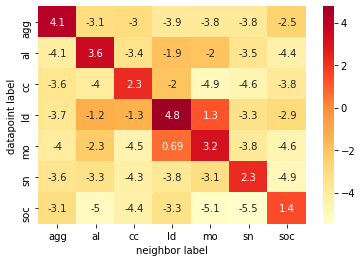

In [230]:
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()
# log2(probability of neighbor label within k nearest neighbors of datapoint / overallll probability of neighbor label)

In [231]:
final_metric = np.mean(np.diagonal(stats_tab_norm))
print("Log final metric (unweighted):",final_metric)

final_metric = np.average(np.diagonal(stats_tab_norm), weights=overall)
print("Log Final metric (weighted):",final_metric)

final_metric = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
print("Abs final metric (unweighted):",final_metric)

final_metric = np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)
print("Abs Final metric (weighted):",final_metric)


Log final metric (unweighted): 3.0908211126976393
Log Final metric (weighted): 2.3134821072355227
Abs final metric (unweighted): 87.90103609606139
Abs Final metric (weighted): 94.01567589576545


Calculate percentage of "correct" neighbors. Overlooking the fact that we don't even desire to always have the same calltype in the ten nearest datapoints, but alright.

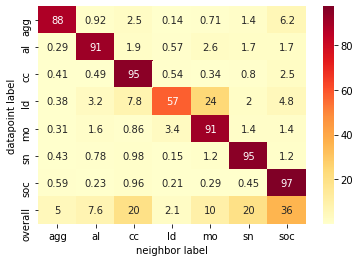

In [232]:
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

In [63]:
np.diagonal(stats_tab.iloc[:-1,])

array([29.57230143, 58.85026738, 53.40392562, 11.68269231, 54.75376884,
       88.88546482, 65.33866819])

# Embedding Optimization

Grid search with different parameters to find the best embedding.
Parameters: 
* UMAP parameters (min_dist, spread, metric)
* inputs (stretched, denoised, MFCC etc)
* adding duration as dimension or not

In [66]:
def make_nn_stats_dict(calltypes, labels, indices):
  nn_stats_dict = {}

  for calltype in calltypes:
    call_indices = np.asarray(np.where(labels==calltype))[0]
    calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

    for i,ind in enumerate(call_indices):
      nearest_neighbors = indices[ind]
      for neighbor in nearest_neighbors:
        neighbor_label = labels[neighbor]
        calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
    nn_stats_dict[calltype] = calltype_counts 
  
  return nn_stats_dict

def get_knn(k,embedding):

  # Scale
  scaler = MinMaxScaler(feature_range=(0,10))
  scaler.fit(embedding)
  embedding = scaler.transform(embedding)
  metric_type = 'euclidean'

  # Find k nearest neighbors
  nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
  distances, indices = nbrs.kneighbors(embedding)

  # need to remove the first neighbor, because that is the datapoint itself
  indices = indices[:,1:]  
  distances = distances[:,1:]

  return indices, distances


def make_statstabs(nn_stats_dict, calltypes, labels):
  # Overall frequencies
  overall = np.zeros((len(calltypes)))
  for i,calltype in enumerate(calltypes):
    overall[i] = sum(labels==calltype)

  overall = (overall/np.sum(overall))*100


  stats_tab = np.zeros((len(calltypes),len(calltypes)))
  stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

  for i, calltype in enumerate(calltypes):
    stats = nn_stats_dict[calltype]
    stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
    stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

  stats_tab = pd.DataFrame(stats_tab)
  stats_tab_norm = pd.DataFrame(stats_tab_norm)

  stats_tab.loc[len(stats_tab)] = overall
  #stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

  stats_tab.columns = calltypes
  stats_tab.index = calltypes+['overall']

  stats_tab_norm.columns = calltypes
  stats_tab_norm.index = calltypes
  stats_tab_norm = np.log2(stats_tab_norm)

  return stats_tab, stats_tab_norm

In [ ]:
k=10
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,2,5] # (scale of embedded points, default 1.0)
metrics = ['euclidean', 'cosine']
n_components_list = [2,5,10]
input_vars = ['spectrograms', 'denoised_spectrograms', 'stretched_spectrograms', 'stretched_denoised_spectrograms', 
          'denoised_mfccs','stretched_mfccs', 'denoised_stretched_mfccs']
add_durations = [True, False]
normalize_list = [True, False]

In [116]:
spec_df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df['index_id'] = spec_df.index
dftype = 'balanced'

labels = spec_df.call_lable.values
calltypes = sorted(list(set(spec_df.call_lable.values)))

f = open("UMAP_optimization.txt","w+")
header = ['k',
          'min_dist',
          'spread',
          'metric',
          'n_components',
          'input_var',
          'add_duration',
          'normalize',
          'mean_log_unweighted', 
          'mean_log_weighted',
          'mean_abs_unweighted',
          'mean_abs_weighted']
header = header+calltypes+calltypes
header_str = ";".join(header)
f.write(header_str+"\r\n")
f.close()

In [69]:
%pwd

'/content/drive/My Drive/meerkat'

In [104]:
# Example with one:
k=10
MIN_DIST = 0
SPREAD = 1
METRIC = 'euclidean'
N_COMPONENTS = 2
INPUT_VAR = 'denoised_spectrograms'
ADD_DURATION = True
NORMALIZE = False


# Open file
f = open("UMAP_optimization.txt","w+")

# Select input data
print('\rPreparing data...',end='')
specs = np.asarray(spec_df[INPUT_VAR])
method = INPUT_VAR

# Flatten and pad with zeros
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)

if NORMALIZE:
  data = StandardScaler().fit_transform(pd.DataFrame(data))

# Run UMAP
print('\rRunning UMAP...',end='')
reducer = umap.UMAP(low_memory=True, 
                    n_components = N_COMPONENTS, 
                    metric = METRIC, 
                    min_dist = MIN_DIST,
                    spread = SPREAD)
embedding = reducer.fit_transform(data)

# Get nearest neighbors
print('\rGetting nearest neighbors...',end='')
indices, distances = get_knn(k,embedding)

# count neighbor labels
print('\rCounting neighbor labels...',end='')
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

# Make statstabs
print('\rMaking statstabs...',end='')
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

# Write results to file
print('\rWrite to file...',end='')
f = open("UMAP_optimization.txt","w+")

params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
params_str = ';'.join([str(x) for x in params])

# Metrics
mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                           np.average(np.diagonal(stats_tab_norm), weights=overall),
                           np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                           np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
all_metrics = np.concatenate((mean_metrics,
                np.diagonal(stats_tab_norm), 
                np.diagonal(stats_tab)))

all_metrics_str = np.char.mod('%f', all_metrics)
all_metrics_str = ";".join(all_metrics_str)

all_results_str = params_str+";"+all_metrics_str
f.write(all_results_str+"\r\n")
f.close()

print('\rDone!',end='')

Done!

Grid search:

In [165]:
k=10
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,5] # (scale of embedded points, default 1.0)
metrics = ['euclidean']
n_components_list = [2,10]

input_vars = ['spectrograms', 'denoised_spectrograms', 'stretched_spectrograms','denoised_stretched_spectrograms', 
          'mfccs','denoised_mfccs','stretched_mfccs', 'denoised_stretched_mfccs']

input_vars = ['mfccs']
normalize_list = [True, False]

for input_var in input_vars:
  for normalize in normalize_list:
    for min_dist in min_dists:
      for metric in metrics:
        for spread in spreads:
          for n_components in n_components_list:
              print(input_var, normalize, min_dist, metric, spread, n_components)

              # Select input data
              print('\rPreparing data...',end='')
              specs = np.asarray(spec_df[input_var])

              # Flatten and pad with zeros
              maxlen= np.max([spec.shape[1] for spec in specs])
              flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
              data = np.asarray(flattened_specs)

              if normalize:
                data = StandardScaler().fit_transform(pd.DataFrame(data))

              # Run UMAP
              print('\rRunning UMAP...',end='')
              reducer = umap.UMAP(low_memory=True, 
                                  n_components = n_components, 
                                  metric = metric, 
                                  min_dist = min_dist,
                                  spread = spread)
              embedding = reducer.fit_transform(data)

              add_duration = False

              # Get nearest neighbors
              print('\rGetting nearest neighbors...',end='')
              indices, distances = get_knn(k,embedding)

              # count neighbor labels
              print('\rCounting neighbor labels...',end='')
              nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

              # Make statstabs
              print('\rMaking statstabs...',end='')
              stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

              # Write results to file
              print('\rWrite to file...',end='')
              f = open("UMAP_optimization.txt","a")

              params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
              params_str = ';'.join([str(x) for x in params])

              # Metrics
              mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                                        np.average(np.diagonal(stats_tab_norm), weights=overall),
                                        np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                                        np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
              all_metrics = np.concatenate((mean_metrics,
                              np.diagonal(stats_tab_norm), 
                              np.diagonal(stats_tab)))

              all_metrics_str = np.char.mod('%f', all_metrics)
              all_metrics_str = ";".join(all_metrics_str)

              all_results_str = params_str+";"+all_metrics_str
              f.write(all_results_str+"\r\n")
              f.close()

              print('\rDone!',end='\n')  

              add_duration = True
              embedding_df = pd.DataFrame(embedding)
              embedding_df['duration'] = spec_df.duration_s.values
              embedding = np.asarray(embedding_df)     


              # Get nearest neighbors
              print('\rGetting nearest neighbors...',end='')
              indices, distances = get_knn(k,embedding)

              # count neighbor labels
              print('\rCounting neighbor labels...',end='')
              nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

              # Make statstabs
              print('\rMaking statstabs...',end='')
              stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

              # Write results to file
              print('\rWrite to file...',end='')
              f = open("UMAP_optimization.txt","a")

              params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
              params_str = ';'.join([str(x) for x in params])

              # Metrics
              mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                                        np.average(np.diagonal(stats_tab_norm), weights=overall),
                                        np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                                        np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
              all_metrics = np.concatenate((mean_metrics,
                              np.diagonal(stats_tab_norm), 
                              np.diagonal(stats_tab)))

              all_metrics_str = np.char.mod('%f', all_metrics)
              all_metrics_str = ";".join(all_metrics_str)

              all_results_str = params_str+";"+all_metrics_str
              f.write(all_results_str+"\r\n")
              f.close()

              print('\rDone!',end='\n') 



mfccs True 0 euclidean 1 2
Done!
Done!
mfccs True 0 euclidean 1 10
Done!
Done!
mfccs True 0 euclidean 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs True 0 euclidean 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs True 0.1 euclidean 1 2
Done!
Done!
mfccs True 0.1 euclidean 1 10
Done!
Done!
mfccs True 0.1 euclidean 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs True 0.1 euclidean 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0 euclidean 1 2
Done!
Done!
mfccs False 0 euclidean 1 10
Done!
Done!
mfccs False 0 euclidean 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0 euclidean 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0.1 euclidean 1 2
Done!
Done!
mfccs False 0.1 euclidean 1 10
Done!
Done!
mfccs False 0.1 euclidean 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0.1 euclidean 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!


In [166]:
opti_table = pd.read_csv(PROJECT_PATH+'UMAP_optimization.txt', sep=";", header=0)

In [167]:
opti_table = opti_table.iloc[:,0:12]

In [233]:
opti_table

,k,min_dist,spread,metric,n_components,input_var,add_duration,normalize,mean_log_unweighted,mean_log_weighted,mean_abs_unweighted,mean_abs_weighted
0,10,0.0,1,euclidean,2,spectrograms,False,True,1.632390,1.391078,40.714325,54.273208
1,10,0.0,1,euclidean,2,spectrograms,True,True,1.580421,1.375525,40.177966,54.035016
2,10,0.0,1,euclidean,10,spectrograms,False,True,1.662180,1.423559,41.757356,55.358306
3,10,0.0,1,euclidean,10,spectrograms,True,True,1.662421,1.423717,41.743966,55.380700
4,10,0.0,5,euclidean,2,spectrograms,False,True,1.653599,1.408534,41.302052,54.873779
...,...,...,...,...,...,...,...,...,...,...,...,...
251,10,0.1,1,euclidean,10,mfccs,True,False,1.643667,1.398520,40.806605,54.527687
252,10,0.1,5,euclidean,2,mfccs,False,False,1.625778,1.383386,40.467674,53.984121
253,10,0.1,5,euclidean,2,mfccs,True,False,1.614334,1.380699,40.322100,54.014658
254,10,0.1,5,euclidean,10,mfccs,False,False,1.646063,1.403027,40.941596,54.652891


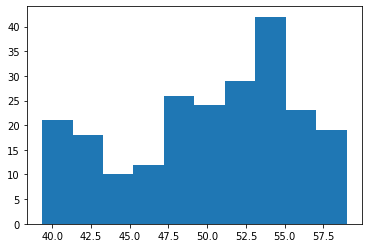

In [133]:
n, bins, patches = plt.hist(opti_table['mean_abs_unweighted'])

In [175]:
import scipy.stats as stats

var_of_interest = 'mean_abs_unweighted'
var_of_interest = 'mean_abs_weighted'
group_var = 'input_var'


res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == input_vars[0]],
               opti_table[var_of_interest][opti_table[group_var] == input_vars[1]],
               opti_table[var_of_interest][opti_table[group_var] == input_vars[2]],
               opti_table[var_of_interest][opti_table[group_var] == input_vars[3]],
               opti_table[var_of_interest][opti_table[group_var] == input_vars[4]],
               opti_table[var_of_interest][opti_table[group_var] == input_vars[5]],
               opti_table[var_of_interest][opti_table[group_var] == input_vars[6]],
               opti_table[var_of_interest][opti_table[group_var] == input_vars[7]]
               )
print(group_var, ":", res.pvalue)

group_var = 'normalize'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == True],
                      opti_table[var_of_interest][opti_table[group_var] == False]
                      )
print(group_var, ":", res.pvalue)

group_var = 'add_duration'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == True],
                      opti_table[var_of_interest][opti_table[group_var] == False]
                      )
print(group_var, ":", res.pvalue)

group_var = 'min_dist'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == min_dists[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  min_dists[1]],
                      )
print(group_var, ":", res.pvalue)

group_var = 'spread'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == spreads[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  spreads[1]],
                      )
print(group_var, ":", res.pvalue)

group_var = 'n_components'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == n_components_list[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  n_components_list[1]],
                      )
print(group_var, ":", res.pvalue)

input_var : 3.708495660914784e-25
normalize : 4.686808976669042e-07
add_duration : 2.207786289942366e-06
min_dist : 0.8315243676956616
spread : 0.5485472907777628
n_components : 1.711661722934918e-08


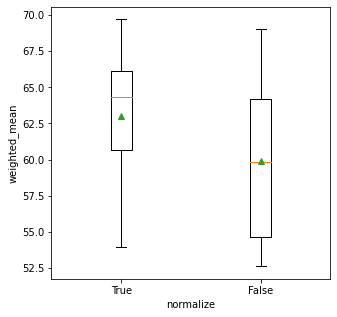

In [176]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'normalize'
data = [opti_table[var_of_interest][opti_table[group_var] == normalize_list[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  normalize_list[1]]]


ax.boxplot(data,
           labels= normalize_list,
           showmeans= True)

plt.xlabel("normalize")
plt.ylabel("weighted_mean")

plt.show()

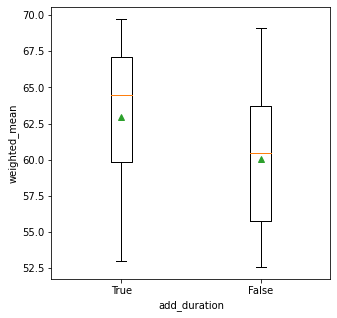

In [177]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'add_duration'
data = [opti_table[var_of_interest][opti_table[group_var] == True],
        opti_table[var_of_interest][opti_table[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.xlabel("add_duration")
plt.ylabel("weighted_mean")

plt.show()

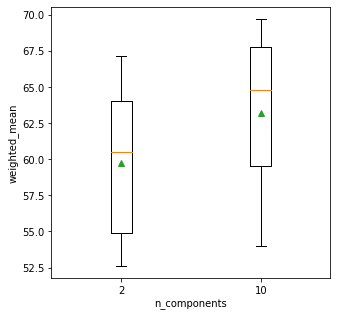

In [178]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'n_components'
data = [opti_table[var_of_interest][opti_table[group_var] == n_components_list[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  n_components_list[1]]]


ax.boxplot(data,
           labels= [n_components_list[0], n_components_list[1]],
           showmeans= True)

plt.xlabel("n_components")
plt.ylabel("weighted_mean")

plt.show()

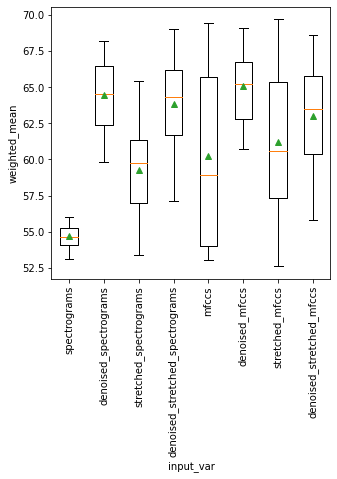

In [179]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set
group_var = 'input_var'
data = [opti_table[var_of_interest][opti_table[group_var] == input_vars[0]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[1]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[2]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[3]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[4]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[5]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[6]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[7]]]


ax.boxplot(data,
           labels= input_vars,
           showmeans= True)

plt.xlabel("input_var")
plt.ylabel("weighted_mean")
plt.xticks(rotation=90)

plt.show()

In [186]:
opti_sorted = opti_table.sort_values(by=['mean_abs_unweighted'], ascending=False)
opti_sorted.loc[opti_sorted['input_var']=='stretched_mfccs',:]

,k,min_dist,spread,metric,n_components,input_var,add_duration,normalize,mean_log_unweighted,mean_log_weighted,mean_abs_unweighted,mean_abs_weighted
175,10,0.1,5,euclidean,10,stretched_mfccs,True,True,2.392587,1.847863,59.000258,69.706840
171,10,0.1,1,euclidean,10,stretched_mfccs,True,True,2.385323,1.843435,58.820351,69.513436
167,10,0.0,5,euclidean,10,stretched_mfccs,True,True,2.375424,1.844438,58.791138,69.640676
163,10,0.0,1,euclidean,10,stretched_mfccs,True,True,2.368370,1.839126,58.525215,69.414699
165,10,0.0,5,euclidean,2,stretched_mfccs,True,True,2.279787,1.782009,56.054739,67.138640
174,10,0.1,5,euclidean,10,stretched_mfccs,False,True,2.314595,1.752338,55.776490,65.209691
166,10,0.0,5,euclidean,10,stretched_mfccs,False,True,2.306350,1.750943,55.615805,65.187296
173,10,0.1,5,euclidean,2,stretched_mfccs,True,True,2.241967,1.766280,55.269754,66.633754
170,10,0.1,1,euclidean,10,stretched_mfccs,False,True,2.290712,1.739103,55.250876,64.680375
162,10,0.0,1,euclidean,10,stretched_mfccs,False,True,2.288451,1.737666,55.130021,64.620318


In [181]:
opti_table.columns

Index(['k', 'min_dist', 'spread', 'metric', 'n_components', 'input_var',
       'add_duration', 'normalize', 'mean_log_unweighted', 'mean_log_weighted',
       'mean_abs_unweighted', 'mean_abs_weighted'],
      dtype='object')